# Magnitude of Surgical Site Infections (SSIs) and Associated Factors among Post-Operative Patients at Myungsung Christian Medical Centre

_By Husna Fazal Ahmed_

### Introduction
Surgical Site Infections (SSIs) are a significant cause of postoperative complications, especially in resource-limited countries. This project aims to predict the likelihood of SSIs using machine learning models and associated factors such as age, comorbidities, and surgery type.


1. Import Necessary Libraries

In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib  # Import joblib for saving/loading models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop


2. Load and Preprocess the Dataset

In [52]:
# Load the dataset
ssi_data = pd.read_csv('/content/data/SSI Data.csv')

# Display the first few rows of the dataset
print(ssi_data.head())

# Identify columns that are of object type (string columns)
object_columns = ssi_data.select_dtypes(include=['object']).columns

# One-hot encode the object columns
for col in object_columns:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(ssi_data[[col]])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col]))
    ssi_data = ssi_data.drop(col, axis=1).reset_index(drop=True)
    ssi_data = pd.concat([ssi_data, encoded_df], axis=1)

# Replace non-numeric values with NaN and fill with 0
ssi_data = ssi_data.replace(' ', np.nan).fillna(0)

# Define features (X) and target (y)
X = ssi_data.drop('SSI', axis=1)  # Replace 'SSI' with the actual target column name
y = ssi_data['SSI']

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


       ID  Sex  Age               Dx Lab    Hg    WBC     Plt  comorbidity  \
0  411773    1    3  Inguinal hernia      18.2   4200   40000            2   
1  437928    2    2   Cholelithiasis      13.8   6000  250000            2   
2  442161    1    3   Cholelithiasis      16.2   9000  241000            1   
3  441665    1    3   Cholelithiasis      13.0  10800  188000            2   
4  419968    1    3   Cholelithiasis      13.5  10900  154000            1   

   HTN  ...  typee  dosee  surgerytype specific  Duration  hospitalstay  ICU  \
0    2  ...                          1       47         2             1    2   
1    2  ...                          1        2         1             1    2   
2    1  ...                          1        2         2             1    2   
3    2  ...                          1        2         2             1    2   
4    1  ...                          1        2         2             1    2   

  transfusion approach SSI  
0           2        

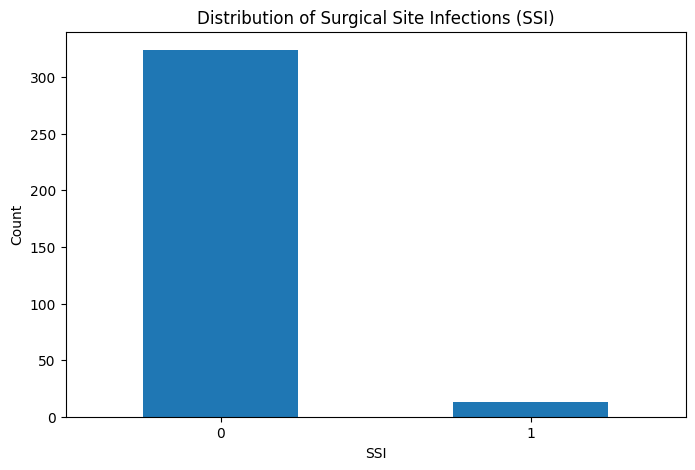

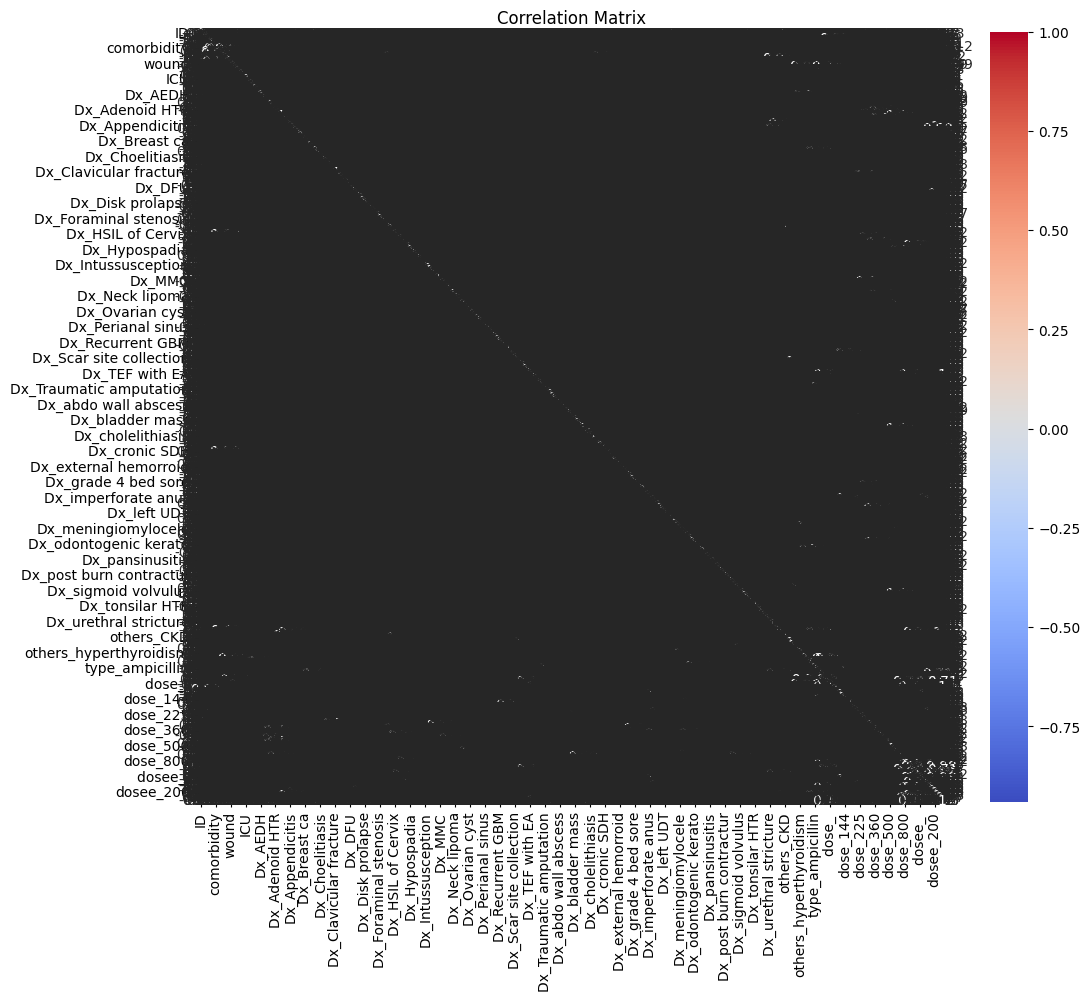

In [60]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar')
plt.title('Distribution of Surgical Site Infections (SSI)')
plt.xlabel('SSI')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Visualize feature correlations
plt.figure(figsize=(12, 10))
correlation_matrix = ssi_data.corr()
plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


3. Define and Train the Simple Neural Network Model

In [53]:
# Define the Simple Neural Network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model using Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0420 - loss: 20118.1172 - val_accuracy: 0.4444 - val_loss: 2152.2986
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6405 - loss: 1615.9404 - val_accuracy: 0.9444 - val_loss: 643.3156
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9603 - loss: 821.2914 - val_accuracy: 0.9444 - val_loss: 1101.5452
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9783 - loss: 609.3117 - val_accuracy: 0.9444 - val_loss: 1281.8354
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9650 - loss: 1080.5791 - val_accuracy: 0.9444 - val_loss: 1287.8053
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9538 - loss: 1434.0792 - val_accuracy: 0.9444 - val_loss: 1202.8114
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9593 - loss: 1100.6073 - val_accuracy: 0.9444 - val_loss: 1069.7533
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9695 - loss: 765.2031 - val_accuracy

4. Evaluate the Model and prediction

In [54]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy}")
# Make predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions

# Generate confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9168 - loss: 14.1572 
Test Accuracy: 0.9117646813392639
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix:
[[62  5]
 [ 1  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        67
           1       0.00      0.00      0.00         1

    accuracy                           0.91        68
   macro avg       0.49      0.46      0.48        68
weighted avg       0.97      0.91      0.94        68



5. Plot Training and Validation Metrics

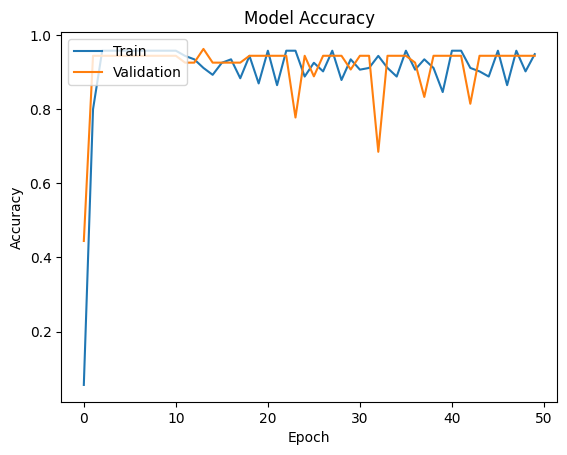

In [55]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


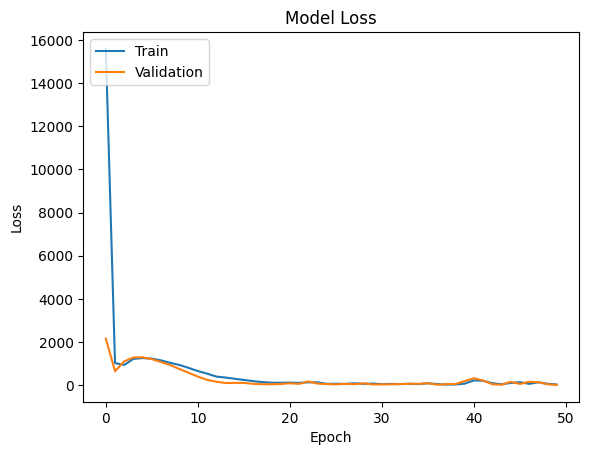

In [56]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


 6.Load Saved Models

In [57]:
!wget https://github.com/Husnafazal/alu-machine_learning/raw/main/SSI%20Project/saved_models/simple_nn_model.h5
!wget https://github.com/Husnafazal/alu-machine_learning/raw/main/SSI%20Project/saved_models/optimized_nn_model.h5

from tensorflow.keras.models import load_model

# Load the models
loaded_simple_model = load_model('simple_nn_model.h5')
loaded_optimized_model = load_model('optimized_nn_model.h5')

print("Models loaded successfully")

# Compile the models to ensure metrics are built
loaded_simple_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])
loaded_optimized_model.compile(optimizer=Adam(learning_rate=0.001),
                                loss='binary_crossentropy',
                                metrics=['accuracy'])



--2024-10-04 10:25:07--  https://github.com/Husnafazal/alu-machine_learning/raw/main/SSI%20Project/saved_models/simple_nn_model.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Husnafazal/alu-machine_learning/main/SSI%20Project/saved_models/simple_nn_model.h5 [following]
--2024-10-04 10:25:07--  https://raw.githubusercontent.com/Husnafazal/alu-machine_learning/main/SSI%20Project/saved_models/simple_nn_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174048 (170K) [application/octet-stream]
Saving to: ‘simple_nn_model.h5.2’

simple_nn_model.h5. 100%[===================>] 169.97K  --.-KB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Models loaded successfully


7. Evaluate Loaded Models

In [58]:
# Evaluate the loaded models on the test data
simple_model_accuracy = loaded_simple_model.evaluate(X_test, y_test, verbose=0)
optimized_model_accuracy = loaded_optimized_model.evaluate(X_test, y_test, verbose=0)

# Print the accuracy of the loaded models
print(f"Loaded Simple Model Accuracy: {simple_model_accuracy[1]}")
print(f"Loaded Optimized Model Accuracy: {optimized_model_accuracy[1]}")


Loaded Simple Model Accuracy: 0.9852941036224365
Loaded Optimized Model Accuracy: 0.7647058963775635


8. Hyperparameter Tuning with GridSearchCV

In [59]:
from sklearn.model_selection import GridSearchCV

# Define the model
logreg = LogisticRegression(max_iter=1000)

# Feature selection using RFECV (Recursive Feature Elimination with Cross-Validation)
selector = RFECV(estimator=logreg, step=1, cv=5)

# Hyperparameters to tune
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2'],
}

# Note: 'logreg__' prefix in param_grid is because of the named step in the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('feature_selection', selector),
    ('logreg', logreg)
])

# GridSearchCV for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Best CV score: 0.9591893780573025


Predict on the Testing Set

In [61]:
# Predict on the testing set
y_pred = grid_search.predict(X_test)

# Evaluate the optimized model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)


Accuracy: 0.9852941176470589
Confusion Matrix:
[[67  0]
 [ 1  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        67
           1       0.00      0.00      0.00         1

    accuracy                           0.99        68
   macro avg       0.49      0.50      0.50        68
weighted avg       0.97      0.99      0.98        68



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
